In [213]:
import tensorflow as tf
from tensorflow .keras import models,layers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [214]:
IMAGE_SIZE=224
BATCH_SIZE=32
CHANNELS=3
EPOCHS=35

In [215]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [216]:
!kaggle datasets download -d emmarex/plantdisease

plantdisease.zip: Skipping, found more recently modified local copy (use --force to force download)


In [217]:
import zipfile
zip_ref = zipfile.ZipFile('/content/plantdisease.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [218]:
%rm -rf /content/plantvillage/PlantVillage/Pepper__bell___Bacterial_spot
%rm -rf /content/plantvillage/PlantVillage/Pepper__bell___healthy
%rm -rf /content/plantvillage/PlantVillage/Tomato_Bacterial_spot
%rm -rf /content/plantvillage/PlantVillage/Tomato_Early_blight
%rm -rf /content/plantvillage/PlantVillage/Tomato_Late_blight
%rm -rf /content/plantvillage/PlantVillage/Tomato_Leaf_Mold
%rm -rf /content/plantvillage/PlantVillage/Tomato_Septoria_leaf_spot
%rm -rf /content/plantvillage/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite
%rm -rf /content/plantvillage/PlantVillage/Tomato__Target_Spot
%rm -rf /content/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus
%rm -rf /content/plantvillage/PlantVillage/Tomato__Tomato_mosaic_virus
%rm -rf /content/plantvillage/PlantVillage/Tomato_healthy

In [219]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/plantvillage/PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [220]:
class_names=dataset.class_names

In [221]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [222]:
len(dataset)

68

In [223]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 224, 224, 3)
[1 0 0 0 0 0 2 1 0 1 0 1 1 0 1 1 1 1 0 1 0 0 2 1 1 0 0 0 0 0 1 0]


In [224]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[155.17348 150.17348 154.17348]
  [155.20918 150.20918 154.20918]
  [158.45918 153.45918 157.45918]
  ...
  [161.92332 156.92332 162.92332]
  [152.81119 147.81119 153.81119]
  [156.21437 151.21437 157.21437]]

 [[156.40306 151.40306 155.40306]
  [149.28061 144.28061 148.28061]
  [150.71428 145.71428 149.71428]
  ...
  [160.42351 155.42351 161.42351]
  [159.88774 154.88774 160.88774]
  [152.99478 147.99478 153.99478]]

 [[149.7602  144.7602  148.7602 ]
  [150.2551  145.2551  149.2551 ]
  [155.14796 150.14796 154.14796]
  ...
  [157.0408  152.0408  158.0408 ]
  [158.33675 153.33675 159.33675]
  [163.0358  158.0358  164.0358 ]]

 ...

 [[119.02554 110.02554 113.02554]
  [121.08165 112.08165 115.08165]
  [125.78571 116.78571 119.78571]
  ...
  [142.58188 136.58188 138.58188]
  [144.6123  138.6123  140.6123 ]
  [140.30605 134.30605 136.30605]]

 [[120.7449  111.7449  114.7449 ]
  [120.35203 111.35203 114.35203]
  [122.36222 113.36222 116.36222]
  ...
  [142.53058 136.53058 138.53058]
  [1

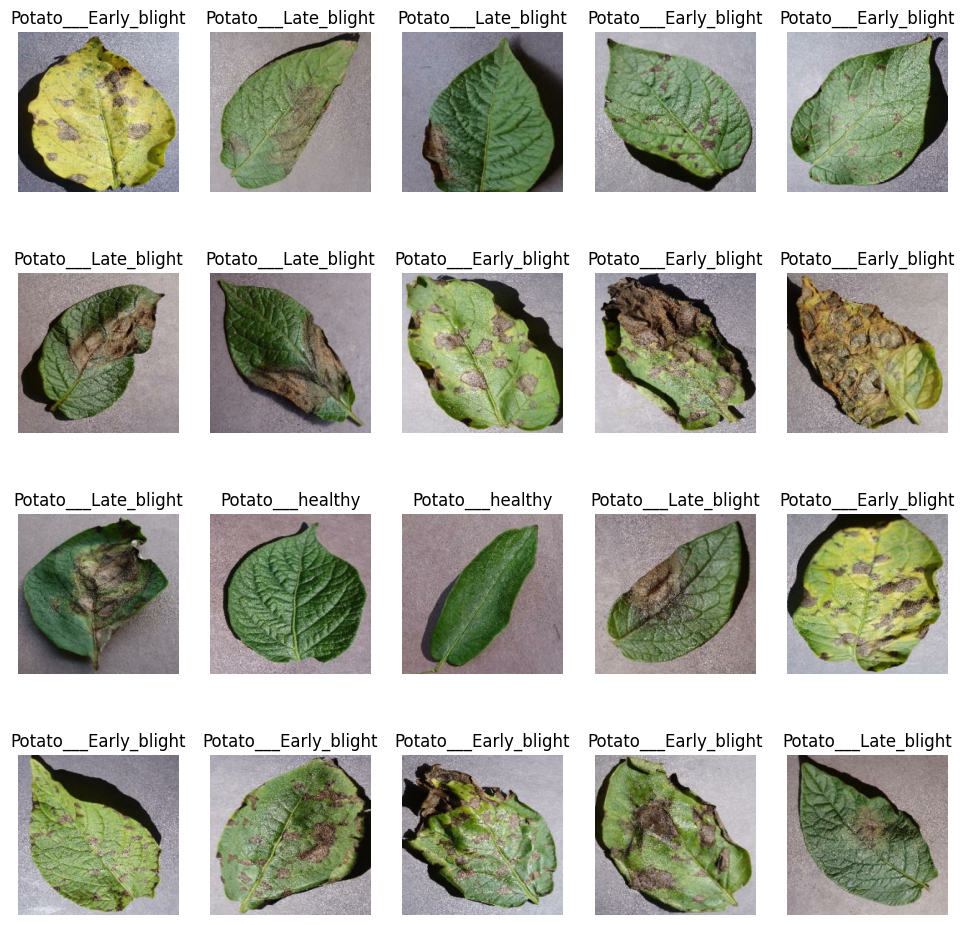

In [225]:
plt.figure(figsize=(12,12))
for image_batch,label_batch in dataset.take(1):
    for i in range(20):
        ax=plt.subplot(4,5,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

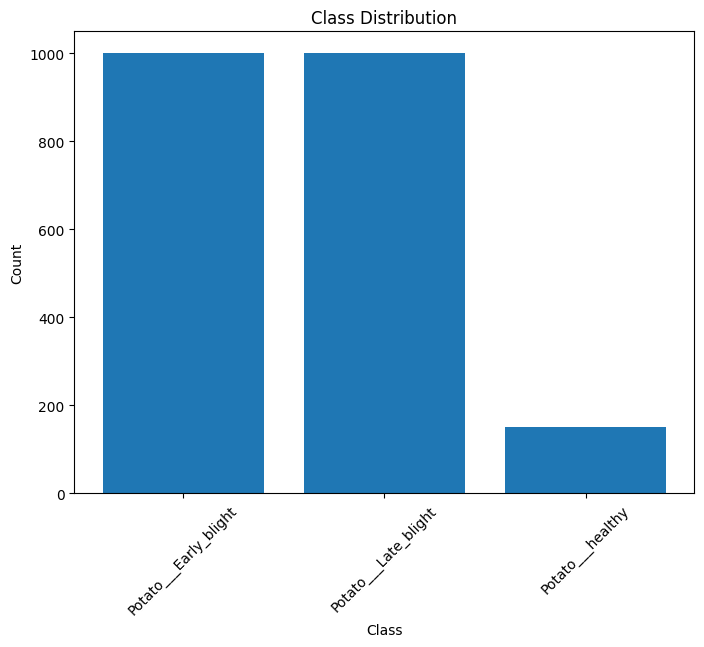

In [226]:
#It willl perform class distribution
plt.figure(figsize=(8, 6))
class_counts = [0] * len(class_names)
for _, labels in dataset:
    for label in labels.numpy():
        class_counts[label] += 1
plt.bar(class_names, class_counts)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [227]:
# Compute and visualize mean and standard deviation of pixel values
mean_pixels = []
std_pixels = []
for images, _ in dataset:
    mean_pixels.append(tf.math.reduce_mean(images, axis=[0, 1, 2]))
    std_pixels.append(tf.math.reduce_std(images, axis=[0, 1, 2]))

mean_pixels = tf.math.reduce_mean(mean_pixels, axis=0)
std_pixels = tf.math.reduce_mean(std_pixels, axis=0)
print("Mean pixel values:", mean_pixels.numpy())
print("Standard deviation of pixel values:", std_pixels.numpy())


Mean pixel values: [125.9979  130.44568 108.85617]
Standard deviation of pixel values: [46.973686 43.250465 53.014328]


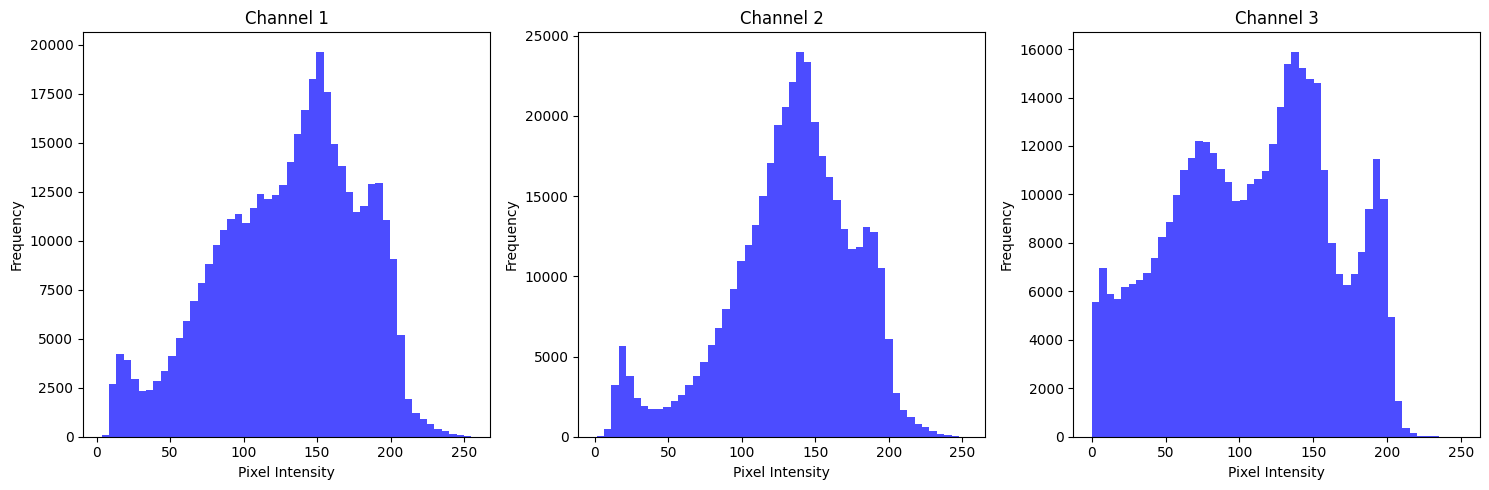

In [228]:
# Plot histogram of pixel intensities for each channel
plt.figure(figsize=(15, 5))
for i in range(CHANNELS):
    plt.subplot(1, CHANNELS, i + 1)
    plt.hist(images[:, :, :, i].numpy().flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Channel {i+1}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [229]:
#Split dataset into train_ds,val_ds,test_ds.
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=121)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [230]:
train_ds,val_ds,test_ds=get_dataset_partition_tf(dataset)

In [231]:
len(train_ds)

54

In [232]:
len(val_ds)

6

In [233]:



len(test_ds)

8

In [234]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [235]:
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [236]:
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [237]:
resize_and_rescale=tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [238]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [239]:
resize_and_rescale

In [240]:

data_augmentation

In [241]:
IMAGE_SIZE

224

In [242]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

In [243]:
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)


In [244]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_21 (Sequential)  (32, 224, 224, 3)         0         
                                                                 
 sequential_22 (Sequential)  (32, 224, 224, 3)         0         
                                                                 
 conv2d_27 (Conv2D)          (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d_21 (MaxPooli  (32, 111, 111, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPooli  (32, 54, 54, 64)          0         
 ng2D)                                               

In [245]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [246]:
history=model.fit(train_ds,batch_size=BATCH_SIZE,validation_data=val_ds,verbose=1,epochs=EPOCHS)

Epoch 1/35
54/54 [==============================] - 10s 90ms/step - loss: 0.9143 - accuracy: 0.4806 - val_loss: 0.8219 - val_accuracy: 0.6667
Epoch 2/35
54/54 [==============================] - 3s 46ms/step - loss: 0.7313 - accuracy: 0.6590 - val_loss: 0.5405 - val_accuracy: 0.7760
Epoch 3/35
54/54 [==============================] - 2s 44ms/step - loss: 0.5439 - accuracy: 0.7576 - val_loss: 0.4769 - val_accuracy: 0.7604
Epoch 4/35
54/54 [==============================] - 2s 44ms/step - loss: 0.5343 - accuracy: 0.7700 - val_loss: 0.5507 - val_accuracy: 0.8021
Epoch 5/35
54/54 [==============================] - 2s 44ms/step - loss: 0.5296 - accuracy: 0.7694 - val_loss: 0.3851 - val_accuracy: 0.8646
Epoch 6/35
54/54 [==============================] - 2s 44ms/step - loss: 0.3841 - accuracy: 0.8398 - val_loss: 0.3175 - val_accuracy: 0.8750
Epoch 7/35
54/54 [==============================] - 2s 46ms/step - loss: 0.3658 - accuracy: 0.8504 - val_loss: 0.4160 - val_accuracy: 0.8021
Epoch 8/35
5

In [247]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 3s 22ms/step - loss: 0.0370 - accuracy: 0.9922


In [248]:
scores

[0.03701965510845184, 0.9921875]

In [249]:
history.params

{'verbose': 1, 'epochs': 35, 'steps': 54}

In [250]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [251]:
history.history['loss']

[0.9142552018165588,
 0.7312642931938171,
 0.5439322590827942,
 0.5342662334442139,
 0.529561460018158,
 0.38414326310157776,
 0.36579960584640503,
 0.3121170699596405,
 0.2573898136615753,
 0.2215563803911209,
 0.17405328154563904,
 0.17168807983398438,
 0.14966242015361786,
 0.1285199373960495,
 0.09805964678525925,
 0.09318626672029495,
 0.12788468599319458,
 0.13501602411270142,
 0.07718916982412338,
 0.0975722074508667,
 0.06923259794712067,
 0.07853753119707108,
 0.09404417127370834,
 0.06611763685941696,
 0.05642302706837654,
 0.04948527365922928,
 0.04242442175745964,
 0.08405128121376038,
 0.043062761425971985,
 0.09090247005224228,
 0.04634151607751846,
 0.03405904024839401,
 0.06757447123527527,
 0.05632583051919937,
 0.040371835231781006]

In [252]:
history.history['accuracy']

[0.48063379526138306,
 0.6590375304222107,
 0.7576290965080261,
 0.7699530720710754,
 0.7693662047386169,
 0.8397887349128723,
 0.8503521084785461,
 0.8779342770576477,
 0.8967136144638062,
 0.922535240650177,
 0.9377934336662292,
 0.9366196990013123,
 0.9413145780563354,
 0.9501173496246338,
 0.9636150002479553,
 0.9589201807975769,
 0.9571596384048462,
 0.9465962648391724,
 0.9653756022453308,
 0.9647887349128723,
 0.9700704216957092,
 0.9724178314208984,
 0.966549277305603,
 0.9759389758110046,
 0.9794601202011108,
 0.9806337952613831,
 0.9829812049865723,
 0.9683098793029785,
 0.987089216709137,
 0.9671361446380615,
 0.9812206625938416,
 0.9900234937667847,
 0.9759389758110046,
 0.9782863855361938,
 0.9835680723190308]

In [253]:
accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']


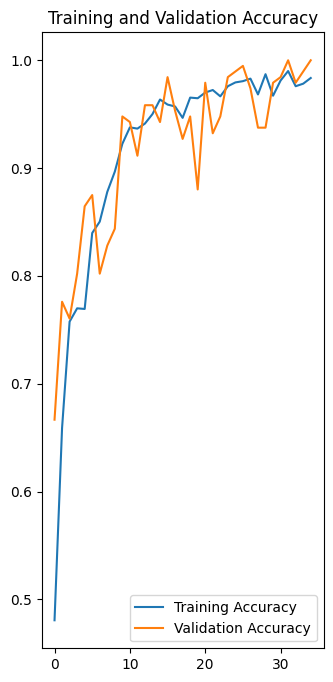

In [254]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),accuracy,label='Training Accuracy')
plt.plot(range(EPOCHS),val_accuracy,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")
plt.show()

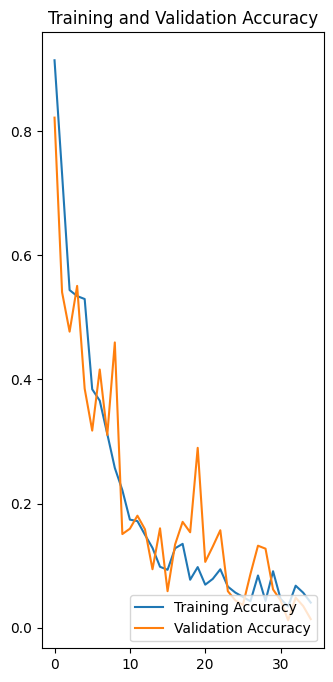

In [255]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),loss,label='Training Accuracy')
plt.plot(range(EPOCHS),val_loss,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")
plt.show()

First Image to predict
Actual Label: Potato___Late_blight
1/1 [==============================] - 0s 119ms/step
Predicted Label: Potato___Late_blight


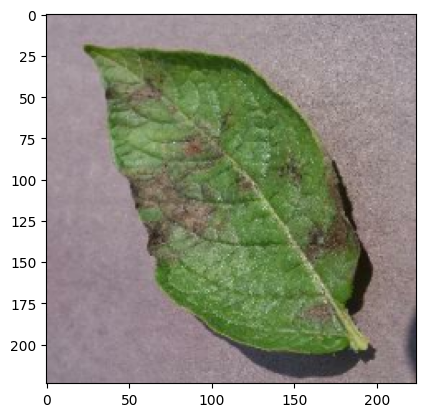

In [256]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype("uint8")
    print("First Image to predict")
    plt.imshow(first_image)
    print("Actual Label:",class_names[labels_batch[0].numpy()])

    batch_prediction=model.predict(images_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [257]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)

    predictions=model.predict(img_array)

    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 18ms/step


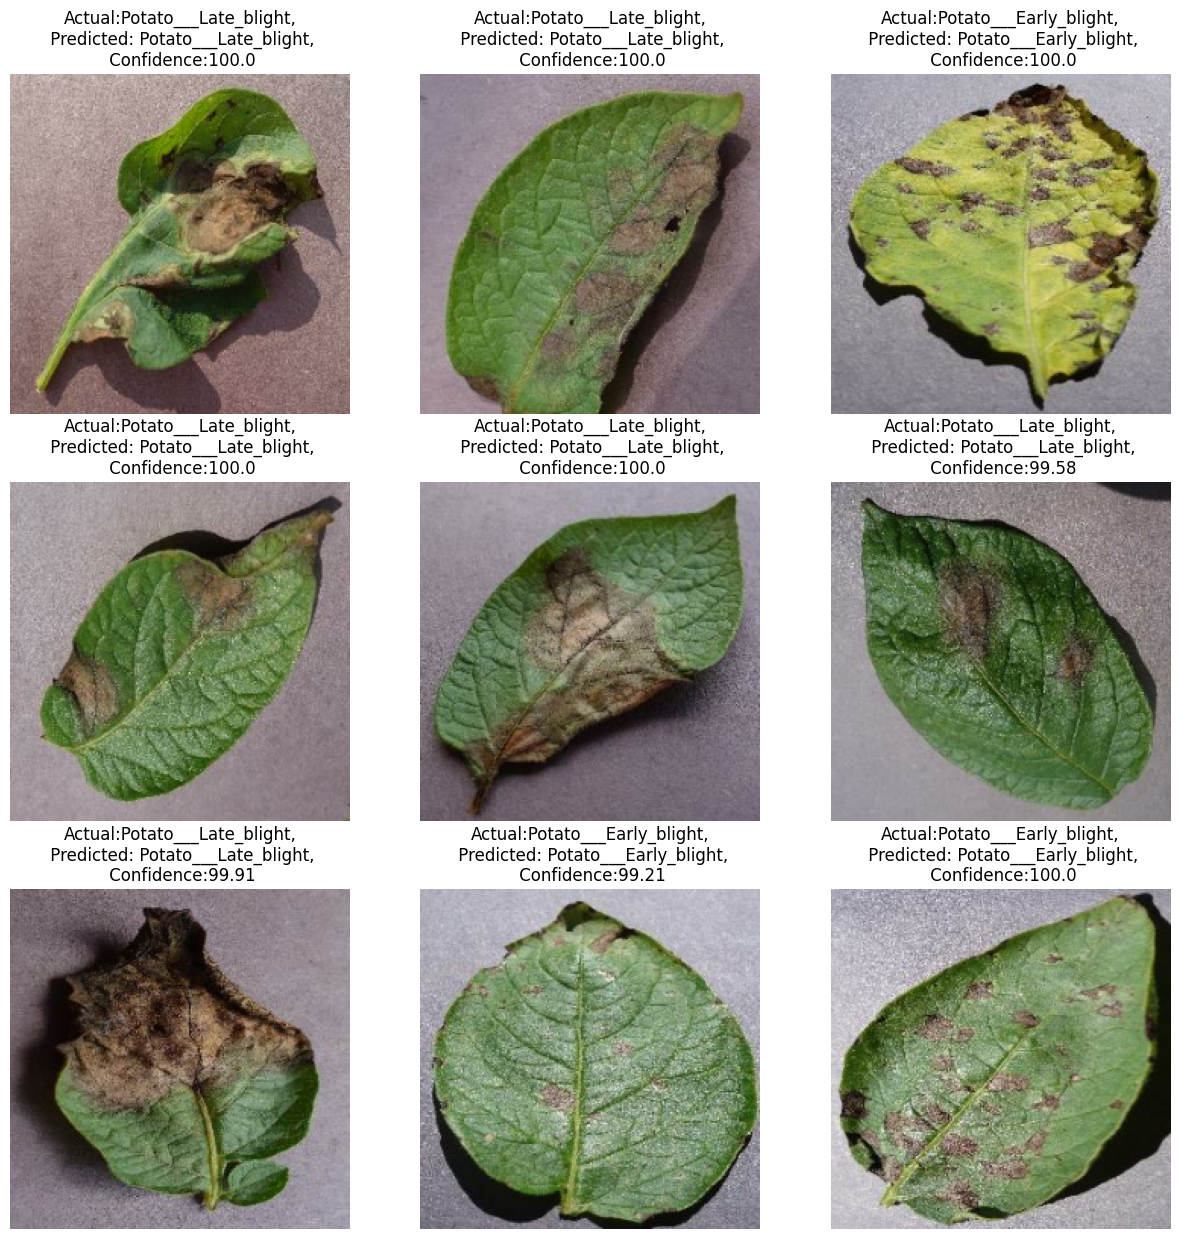

In [258]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())

        actual_class =class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class},\n Confidence:{confidence}")
        plt.axis("off")

In [259]:
#alexnet
from tensorflow import keras

In [260]:
PATCH_SIZE = 32
n_classes = 3


In [261]:
IMAGE_SIZE=224
n_classes = 3

resize_and_rescale = keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE)
])

data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [262]:
resize_and_rescale

In [263]:
data_augmentation

In [264]:


input_shape = (224, 224, 3)  # Example input shape for AlexNe
alexNet_model = models.Sequential([
    data_augmentation,
    # First Convolutional Layer
    layers.Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    # Second Convolutional Layer
    layers.Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    # Third Convolutional Layer
    layers.Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'),

    # Fourth Convolutional Layer
    layers.Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'),

    # Fifth Convolutional Layer
    layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    layers.Flatten(),

    # First Dense Layer
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),

    # Second Dense Layer
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),

    # Output layer
    layers.Dense(n_classes, activation='softmax')
])




In [265]:
alexNet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [266]:
history = alexNet_model.fit(train_ds, batch_size=BATCH_SIZE, validation_data=val_ds, verbose=1, epochs=EPOCHS)

Epoch 1/35
54/54 [==============================] - 7s 52ms/step - loss: 6.3856 - accuracy: 0.6978 - val_loss: 216.3018 - val_accuracy: 0.4740
Epoch 2/35
54/54 [==============================] - 2s 45ms/step - loss: 1.0488 - accuracy: 0.7840 - val_loss: 66.1496 - val_accuracy: 0.4740
Epoch 3/35
54/54 [==============================] - 2s 46ms/step - loss: 0.5919 - accuracy: 0.8239 - val_loss: 2.4760 - val_accuracy: 0.5885
Epoch 4/35
54/54 [==============================] - 2s 46ms/step - loss: 0.5382 - accuracy: 0.8310 - val_loss: 0.9364 - val_accuracy: 0.7188
Epoch 5/35
54/54 [==============================] - 3s 48ms/step - loss: 0.4164 - accuracy: 0.8521 - val_loss: 0.4193 - val_accuracy: 0.8438
Epoch 6/35
54/54 [==============================] - 3s 47ms/step - loss: 0.3963 - accuracy: 0.8709 - val_loss: 0.9537 - val_accuracy: 0.5365
Epoch 7/35
54/54 [==============================] - 2s 46ms/step - loss: 0.3692 - accuracy: 0.8727 - val_loss: 2.6053 - val_accuracy: 0.4948
Epoch 8/35

In [267]:
alexNet_model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_25 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization_9 (Bat  (None, 54, 54, 96)        384       
 chNormalization)                                                
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 26, 26, 96)        0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 26, 26, 256)       614656    
                                                                 
 batch_normalization_10 (Ba  (None, 26, 26, 256)     

In [268]:
scores=alexNet_model.evaluate(test_ds)

8/8 [==============================] - 0s 19ms/step - loss: 0.1093 - accuracy: 0.9727


In [269]:
scores

[0.10926192998886108, 0.97265625]

In [270]:
accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']


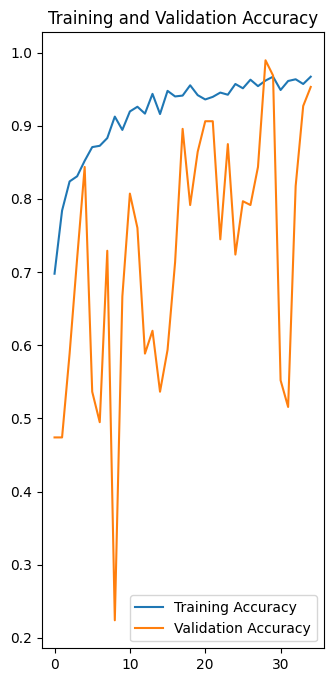

In [271]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),accuracy,label='Training Accuracy')
plt.plot(range(EPOCHS),val_accuracy,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")
plt.show()

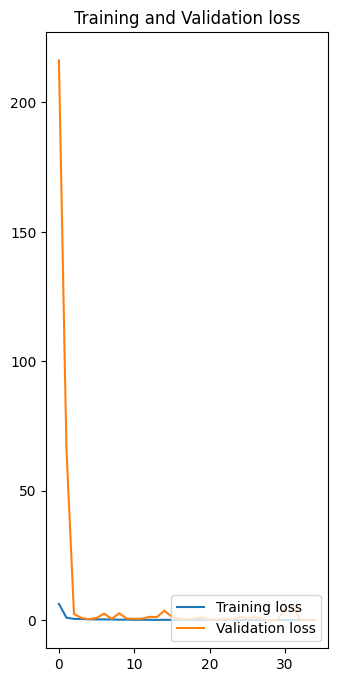

In [272]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),loss,label='Training loss')
plt.plot(range(EPOCHS),val_loss,label='Validation loss')
plt.legend(loc='lower right')
plt.title("Training and Validation loss")
plt.show()

First Image to predict
Actual Label: Potato___Late_blight
1/1 [==============================] - 0s 131ms/step
Predicted Label: Potato___Late_blight


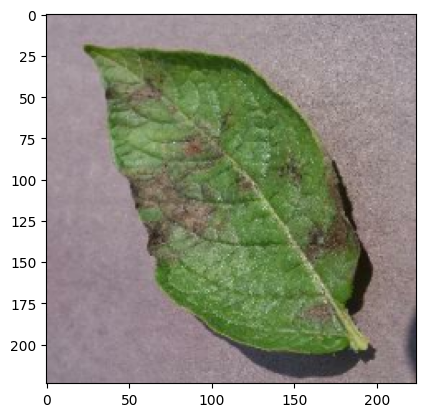

In [273]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype("uint8")
    print("First Image to predict")
    plt.imshow(first_image)
    print("Actual Label:",class_names[labels_batch[0].numpy()])

    batch_prediction=alexNet_model.predict(images_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [274]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)

    predictions=alexNet_model.predict(img_array)

    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 27ms/step


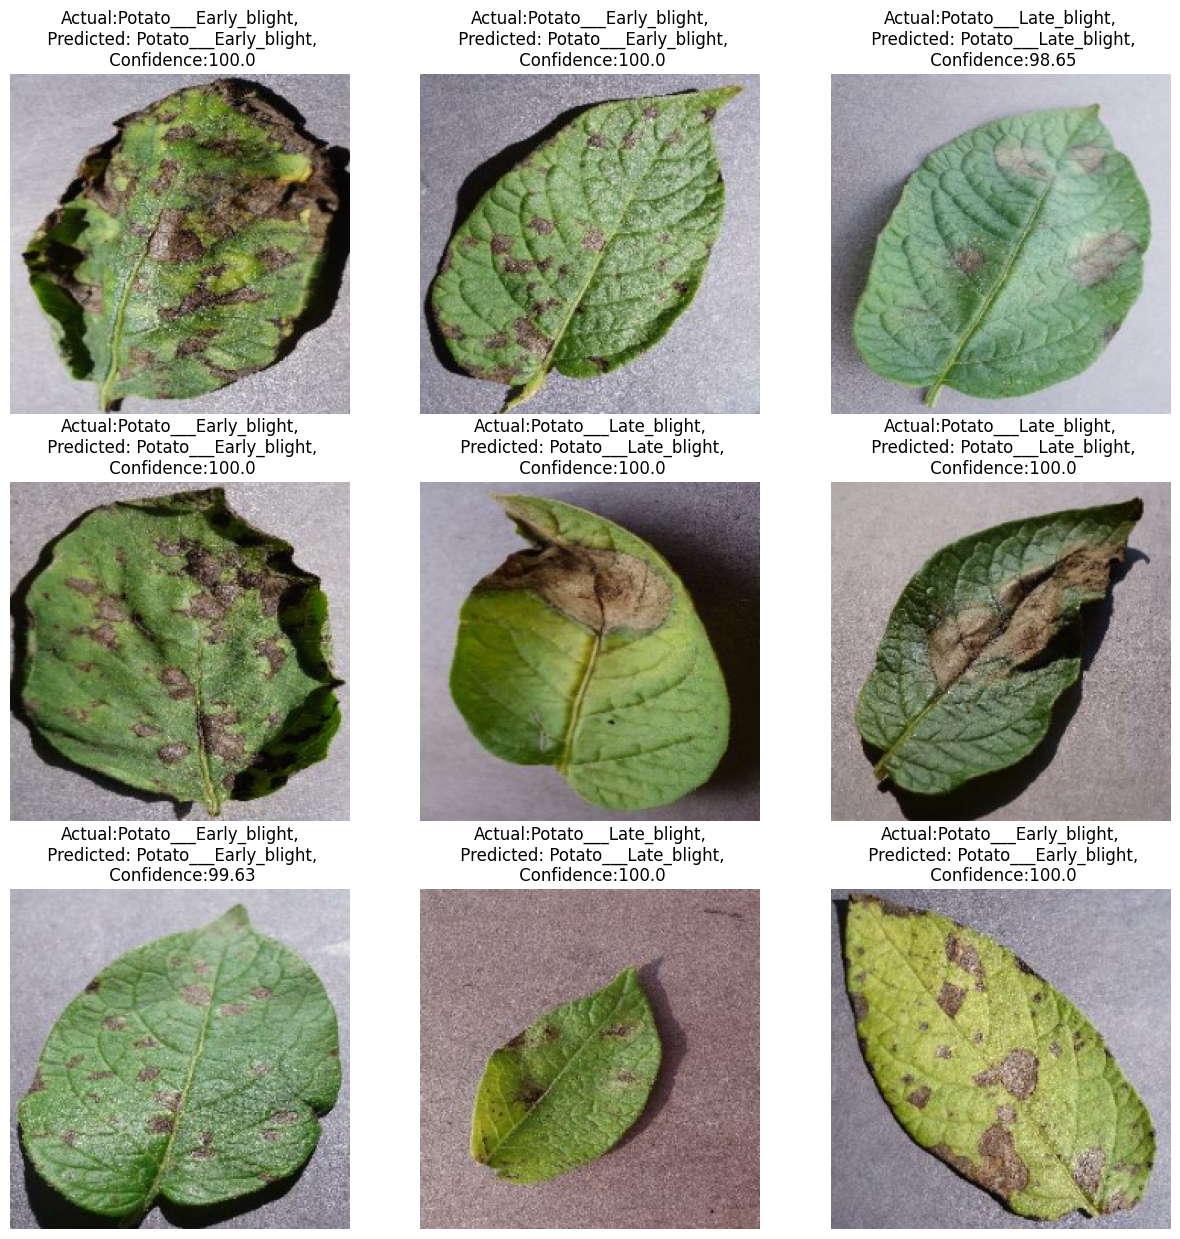

In [275]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(alexNet_model,images[i].numpy())

        actual_class =class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class},\n Confidence:{confidence}")
        plt.axis("off")

In [276]:
# Define the RNN part of the model (LSTM layer)
rnn_model = models.Sequential([
    # resize_and_rescale,
    data_augmentation,
    layers.LSTM(256, return_sequences=True),
    layers.LSTM(256)
])



In [277]:
cnn_output = alexNet_model.output

# Determine the number of features in the CNN output
num_features = cnn_output.shape[-1]

# Reshape the CNN output to match the input shape of the RNN model
reshaped_output = layers.Reshape((-1, num_features))(cnn_output)

# Pass the reshaped output through the RNN model
rnn_output = rnn_model(reshaped_output)


combined_model = models.Model(inputs=alexNet_model.input, outputs=rnn_output)

# Compile the model
combined_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Display summary
combined_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_25_input (Input  [(None, 224, 224, 3)]     0         
 Layer)                                                          
                                                                 
 sequential_25 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization_9 (Bat  (None, 54, 54, 96)        384       
 chNormalization)                                                
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 26, 26, 96)        0         
 ng2D)                                                           
                                                           

In [278]:
combined_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
combined_model.summary()
history = combined_model.fit(train_ds, batch_size=BATCH_SIZE, validation_data=val_ds, verbose=1, epochs=EPOCHS)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_25_input (Input  [(None, 224, 224, 3)]     0         
 Layer)                                                          
                                                                 
 sequential_25 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization_9 (Bat  (None, 54, 54, 96)        384       
 chNormalization)                                                
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 26, 26, 96)        0         
 ng2D)                                                           
                                                           

In [279]:
scores=combined_model.evaluate(test_ds)

8/8 [==============================] - 0s 17ms/step - loss: 0.8557 - accuracy: 0.4648


In [280]:
scores

[0.8557091355323792, 0.46484375]

In [281]:
accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']


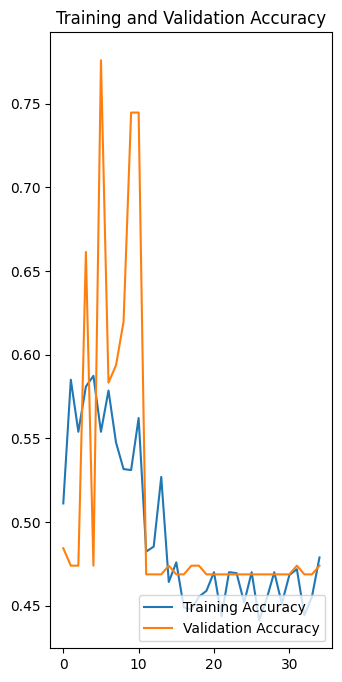

In [282]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),accuracy,label='Training Accuracy')
plt.plot(range(EPOCHS),val_accuracy,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")
plt.show()

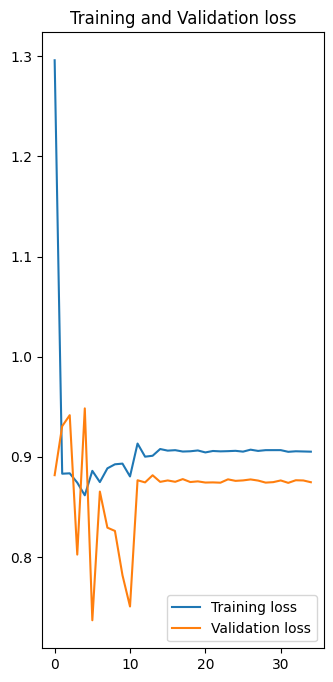

In [283]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),loss,label='Training loss')
plt.plot(range(EPOCHS),val_loss,label='Validation loss')
plt.legend(loc='lower right')
plt.title("Training and Validation loss")
plt.show()

First Image to predict
Actual Label: Potato___Late_blight
1/1 [==============================] - 1s 703ms/step
Predicted Label: Potato___Early_blight


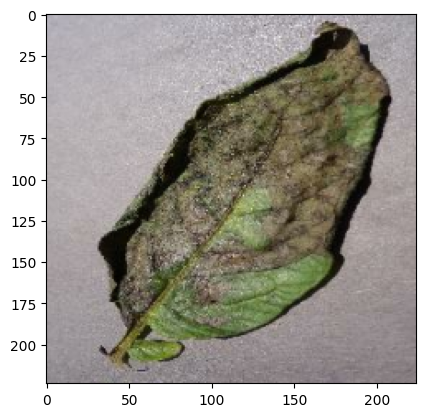

In [284]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype("uint8")
    print("First Image to predict")
    plt.imshow(first_image)
    print("Actual Label:",class_names[labels_batch[0].numpy()])

    batch_prediction=combined_model.predict(images_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [285]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)

    predictions=combined_model.predict(img_array)

    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 27ms/step


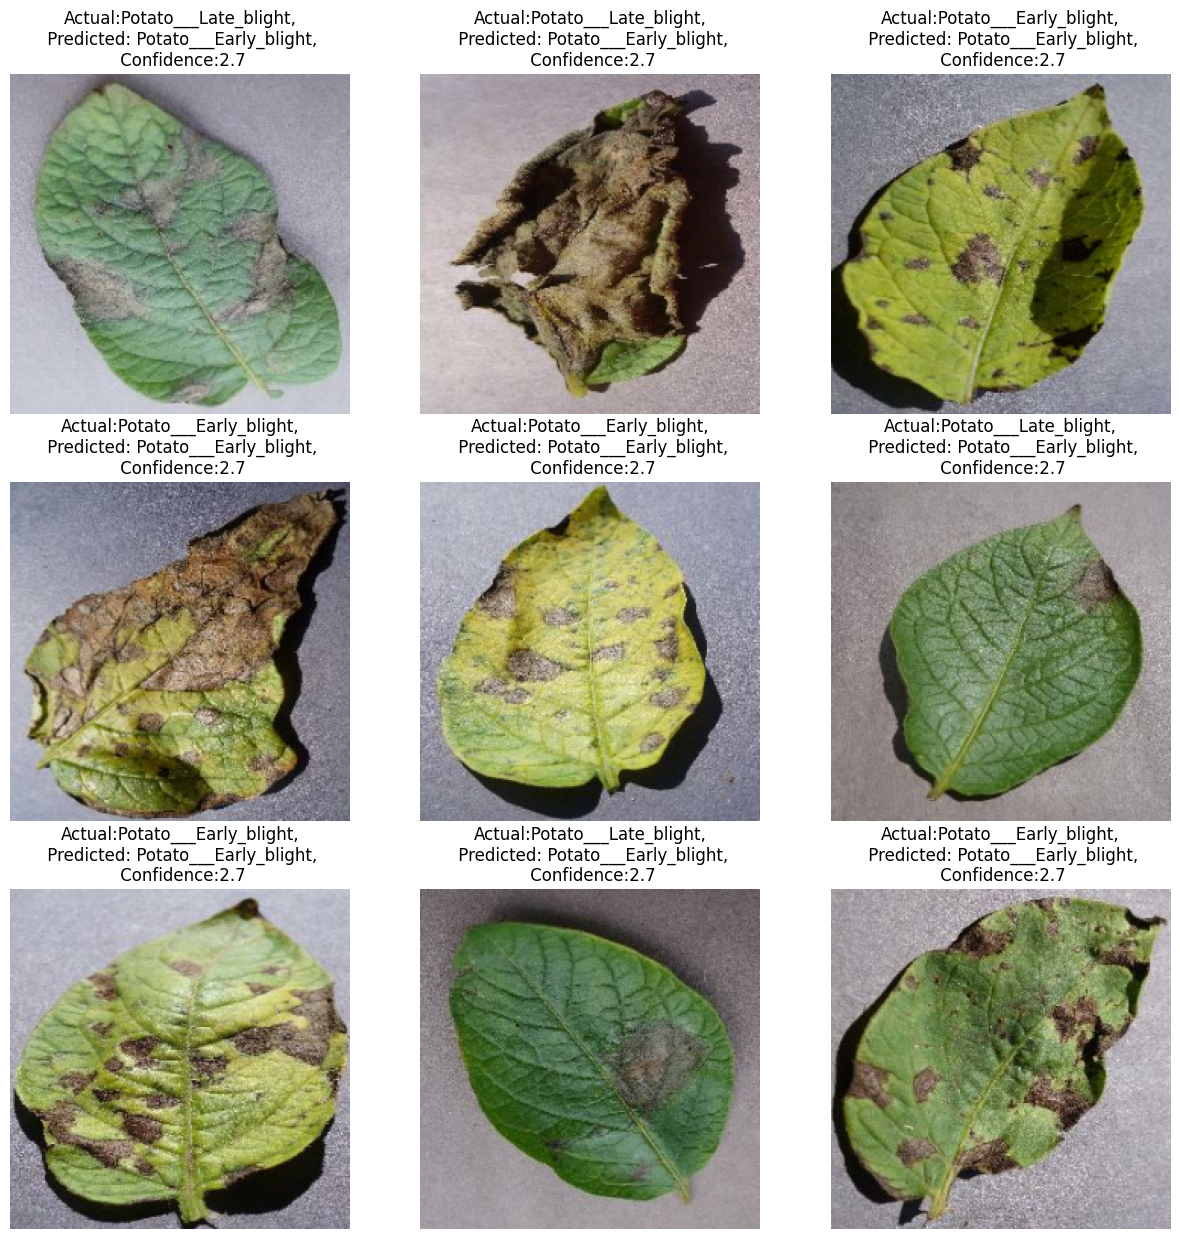

In [286]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(combined_model,images[i].numpy())

        actual_class =class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class},\n Confidence:{confidence}")
        plt.axis("off")